# Utilizando o merge-downloader

## Obtendo série temporal

In [1]:
# Loading packages
import geopandas as gpd
import xarray as xr
from mergedownloader.downloader import Downloader
from mergedownloader.inpeparser import INPEParsers, INPETypes
# from mergedownloader.utils import GISUtil
from shapely import Point
import matplotlib.pyplot as plt

In [2]:
# Set download local folder
download_folder = 'D:\Pesquisa\PIBIC_23-24\Dados_GPM\Test'

In [3]:
# Create an instance
downloader = Downloader(
    server=INPEParsers.FTPurl, 
    parsers=INPEParsers.parsers,
    local_folder=download_folder
)

In [4]:
# Create cube with daily rain
cube = downloader.create_cube(
    start_date='2022-01-01',  # Período de início dos dados
    end_date='2022-01-31',  # Período final dos dados
    datatype=INPETypes.DAILY_RAIN  # Tipo de dado (diário)
)

## Convertendo para um dataframe

In [5]:
# Create list with precipitation data
import glob

filename = glob.glob("D:\Pesquisa\PIBIC_23-24\Dados_GPM\Test\DAILY_RAIN\*.grib2")

In [6]:
# Create the dataframe with precipitation
import pandas as pd

final_df = pd.DataFrame()

for file in filename:
    ds = xr.open_dataset(file, engine='cfgrib')
    ds = ds.get('prec')
    df = ds.to_dataframe()
    final_df = pd.concat([final_df, df])

In [7]:
# Number of data
print('Quantidade de dados de chuva no dataset: ', final_df.shape[0])

Quantidade de dados de chuva no dataset:  28672644


In [8]:
# Unpackage the longitude and latitude data
latitudes = final_df.index.get_level_values('latitude')
longitudes = final_df.index.get_level_values('longitude')

In [9]:
# Convert range of longitude values
map_function = lambda lon: (lon - 360) if (lon > 180) else lon
remapped_longitudes = longitudes.map(map_function)

In [10]:
# Create columns
final_df['longitude'] = remapped_longitudes
final_df['latitude'] = latitudes

In [11]:
# Format dataframe
df_formatted = final_df.reset_index(drop=True)
df_formatted = df_formatted.drop(columns=['time', 'step', 'surface'])

## Criando um GeoDataFrame e fazendo manipulações

In [12]:
# Convert for GeoDataFrame
geometry = [Point(coords) for coords in zip(df_formatted['longitude'], df_formatted['latitude'])]
gdf = gpd.GeoDataFrame(data=df_formatted, geometry=geometry)

In [13]:
# Sertão Alagoano data
sertao = "D:\Pesquisa\PIBIC_23-24\GIS\Sertao.shp"
gdf_sertao = gpd.read_file(filename=sertao)
gdf_sertao

,RAmbiental,geometry
0,Sertão,"POLYGON ((-37.75222 -8.85316, -37.75111 -8.855..."
1,Sertão do São Francisco,"POLYGON ((-37.87638 -9.40437, -37.87228 -9.406..."


In [14]:
# Clip data rain
gdf.set_crs('4674', inplace=True)
prec_clip = gpd.clip(gdf=gdf, mask=gdf_sertao)
prec_clip.reset_index(drop=True, inplace=True)

In [15]:
# Create ID column
list_geom_u = list(set(prec_clip['geometry'].values))
prec_clip.loc[:, 'ID'] = -99

for row in range(len(prec_clip)):
    for i in range(len(list_geom_u)):
        if list_geom_u[i] == prec_clip.iloc[row]['geometry']:
            prec_clip.loc[row, 'ID'] = i

c:\Users\pedro\anaconda3\envs\GPM\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [16]:
# Create pivot table
prec_Series = prec_clip.pivot_table(values='prec', index='ID', columns='valid_time')
prec_Series = gpd.GeoDataFrame(prec_Series, geometry=list_geom_u)
prec_Series.head()

valid_time,2022-01-01 12:00:00,2022-01-02 12:00:00,2022-01-03 12:00:00,2022-01-04 12:00:00,2022-01-05 12:00:00,2022-01-06 12:00:00,2022-01-07 12:00:00,2022-01-08 12:00:00,2022-01-09 12:00:00,2022-01-10 12:00:00,...,2022-01-23 12:00:00,2022-01-24 12:00:00,2022-01-25 12:00:00,2022-01-26 12:00:00,2022-01-27 12:00:00,2022-01-28 12:00:00,2022-01-29 12:00:00,2022-01-30 12:00:00,2022-01-31 12:00:00,geometry
ID,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.00,0.00,10.125,0.500,0.0,0.0,0.0,...,0.0,0.0,2.000,0.000,0.2500,0.0,18.750,1.750,3.3125,POINT (-37.45000 -9.35000)
1,0.0,0.0,0.0,0.25,0.25,3.250,0.375,0.0,0.0,0.0,...,0.0,0.0,0.000,0.125,0.7500,0.0,11.375,0.250,2.4375,POINT (-37.15000 -9.45000)
2,0.0,0.0,0.0,0.00,0.00,12.500,1.125,0.0,0.0,0.0,...,0.0,0.0,2.000,0.000,0.2500,0.0,25.500,6.875,3.3125,POINT (-37.65000 -9.25000)
3,0.0,0.0,0.0,0.00,0.00,11.000,1.375,0.0,0.0,0.0,...,0.0,0.0,0.625,0.000,0.0625,0.0,19.750,3.000,2.8750,POINT (-37.75000 -9.55000)
4,0.0,0.0,0.0,0.00,0.00,9.750,0.375,0.0,0.0,0.0,...,0.0,0.0,0.625,0.000,0.1250,0.0,12.625,1.250,3.5625,POINT (-37.45000 -9.45000)


## Obter as 4 estações mais próximas

In [17]:
# Gage stations coordinates (Delmiro Gouveia) for future comparisons
lat = -9.3928 
lng = -37.9942
gage = Point(lng, lat)
gdf_gage = gpd.GeoDataFrame(data=[] ,geometry=[gage])
gdf_gage

,geometry
0,POINT (-37.99420 -9.39280)


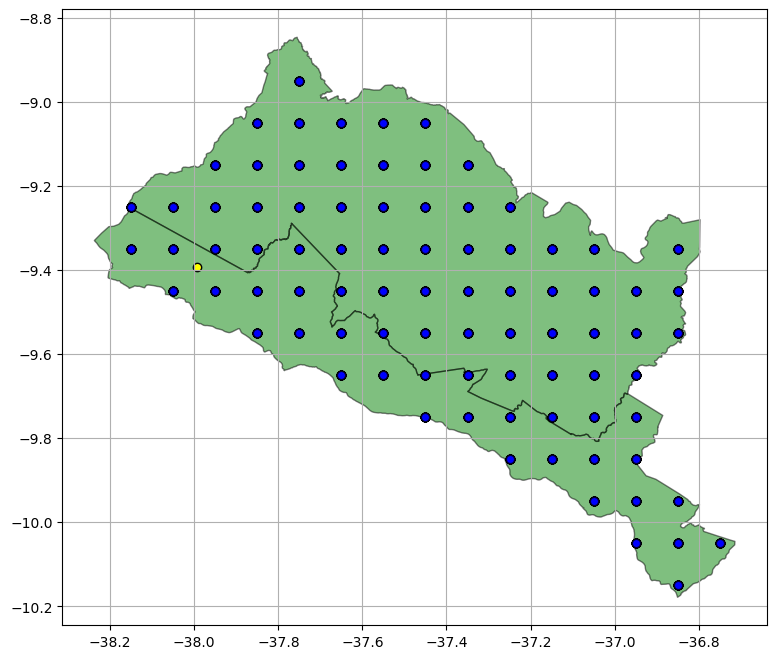

In [18]:
# Plot map
fig, ax = plt.subplots(figsize=(12, 8))

gdf_sertao.plot(alpha=.5,
                color='g',
                edgecolor='black',
                ax=ax)

prec_clip.plot(color='blue',
               ax=ax,
               alpha=.6,
               edgecolor='black')

gdf_gage.plot(color='yellow',
          edgecolor='black',
          ax=ax)

plt.grid(visible=True)
plt.show()

In [19]:
# Euclidian distance function
import numpy as np

def euclidian_distance(ref_point, virtual_point):
    dist = np.sqrt((ref_point['geometry'].x[0] - virtual_point[-1].x) ** 2 + (ref_point['geometry'].y[0] - virtual_point[-1].y) ** 2)
    return dist

In [20]:
# Compute distance
for rows in prec_Series.itertuples():
    d = euclidian_distance(gdf_gage, rows)
    prec_Series.loc[rows[0], 'distance'] = d

In [21]:
# 4 Closest gage stations
prec_closest = prec_Series.sort_values(by='distance', ascending=True)[:4]
prec_closest

valid_time,2022-01-01 12:00:00,2022-01-02 12:00:00,2022-01-03 12:00:00,2022-01-04 12:00:00,2022-01-05 12:00:00,2022-01-06 12:00:00,2022-01-07 12:00:00,2022-01-08 12:00:00,2022-01-09 12:00:00,2022-01-10 12:00:00,...,2022-01-24 12:00:00,2022-01-25 12:00:00,2022-01-26 12:00:00,2022-01-27 12:00:00,2022-01-28 12:00:00,2022-01-29 12:00:00,2022-01-30 12:00:00,2022-01-31 12:00:00,geometry,distance
ID,,,,,,,,,,,,,,,,,,,,,
55,0.0,0.0,0.0,0.0,0.0,15.50,2.125,0.0,0.0,0.0,...,0.0,0.625,0.0,0.0625,0.0,47.875,9.000,3.2500,POINT (-37.95000 -9.35000),0.061526
62,0.0,0.0,0.0,0.0,0.0,11.25,3.625,0.0,0.0,0.0,...,0.0,2.375,0.0,0.1250,0.0,36.750,7.500,1.8125,POINT (-38.05000 -9.35000),0.070324
66,0.0,0.0,0.0,0.0,0.0,11.00,1.875,0.0,0.0,0.0,...,0.0,1.125,0.0,0.0625,0.0,34.625,9.125,2.3750,POINT (-37.95000 -9.45000),0.072287
60,0.0,0.0,0.0,0.0,0.0,8.25,2.500,0.0,0.0,0.0,...,0.0,2.000,0.0,0.1250,0.0,30.875,8.125,1.5625,POINT (-38.05000 -9.45000),0.079909


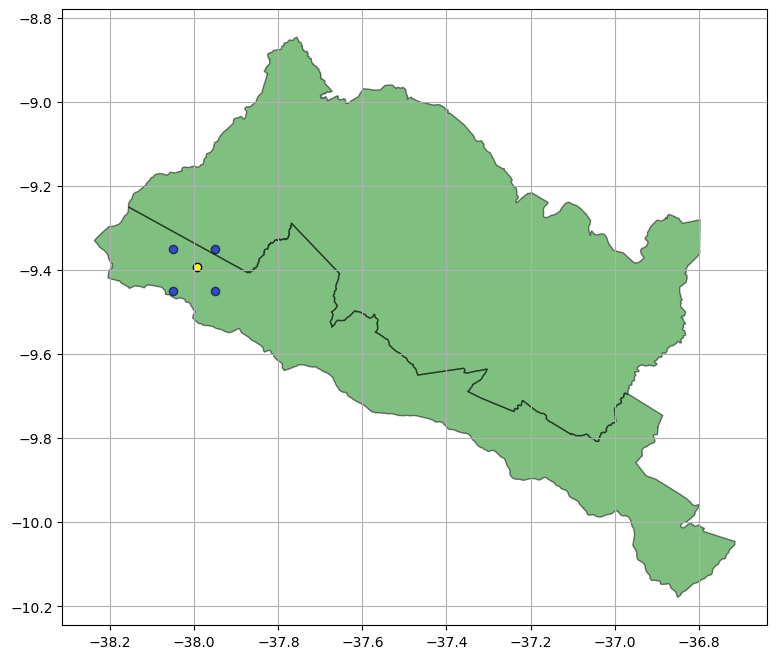

In [22]:
# Plot map
fig, ax = plt.subplots(figsize=(12, 8))

gdf_sertao.plot(alpha=.5,
                color='g',
                edgecolor='black',
                ax=ax)

prec_closest.plot(color='blue',
               ax=ax,
               alpha=.6,
               edgecolor='black')

gdf_gage.plot(color='yellow',
          edgecolor='black',
          ax=ax)

plt.grid(visible=True)
plt.show()

# Realizar uma interpolação bilinear

In [23]:
# Bilinear interpolation function
def bilinear_interpolation(long_coord, lat_coord, coords):
    """Interpolate (x,y) from values associated with four points.

    The four points are a list of four triplets:  (x, y, value).
    The four points can be in any order.  They should form a rectangle.

        >>> bilinear_interpolation(12, 5.5,
        ...                        [(10, 4, 100),
        ...                         (20, 4, 200),
        ...                         (10, 6, 150),
        ...                         (20, 6, 300)])
        165.0

    """

    coords = sorted(coords)               # order points by x, then by y
    (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = coords

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError('points do not form a rectangle')
    if not x1 <= long_coord <= x2 or not y1 <= lat_coord <= y2:
        raise ValueError('(x, y) not within the rectangle')

    return (q11 * (x2 - long_coord) * (y2 - lat_coord) +
            q21 * (long_coord - x1) * (y2 - lat_coord) +
            q12 * (x2 - long_coord) * (lat_coord - y1) +
            q22 * (long_coord - x1) * (lat_coord - y1)
           ) / ((x2 - x1) * (y2 - y1) + 0.0)

In [24]:
# Organize arguments
x = gdf_gage['geometry'].x[0]
y = gdf_gage['geometry'].y[0]
coords = []

rainfall_gage = pd.DataFrame(index=[prec_closest.columns[:-2]], columns=['rain(mm)'])

In [25]:
# Interpolate values and set the series
for d in range(prec_closest.shape[1] - 2):
    p1 = (prec_closest.iloc[0].loc['geometry'].x, prec_closest.iloc[0].loc['geometry'].y, prec_closest.iloc[0].iloc[d])
    p2 = (prec_closest.iloc[1].loc['geometry'].x, prec_closest.iloc[1].loc['geometry'].y, prec_closest.iloc[1].iloc[d])
    p3 = (prec_closest.iloc[2].loc['geometry'].x, prec_closest.iloc[2].loc['geometry'].y, prec_closest.iloc[2].iloc[d])
    p4 = (prec_closest.iloc[3].loc['geometry'].x, prec_closest.iloc[3].loc['geometry'].y, prec_closest.iloc[3].iloc[d])
    
    coords = [p1, p2, p3, p4]
    
    rainfall_gage.loc[rainfall_gage.iloc[d].name, 'rain(mm)'] = bilinear_interpolation(x, y, coords)
    

# Comparar valores observados com os estimados

In [26]:
# Load the observed data
observed_data = pd.read_excel(io="D:\Pesquisa\PIBIC_23-24\Estacoes\Estacoes_SIGA\DELMIRO_GOUVEIA.xlsx", header=6, index_col=1)
observed_data.drop(labels=['Unnamed: 0'], axis=1, inplace=True)
observed_data

,Precipitação
Data,
1936-04-01,0.0
1936-04-02,0.0
1936-04-03,0.0
1936-04-04,0.0
1936-04-05,0.0
...,...
2023-06-26,1.7
2023-06-27,0.0
2023-06-28,4.7


In [27]:
# Filter the date
data_filter = observed_data.loc['2022-01']
data_filter

,Precipitação
Data,
2022-01-01,0.0
2022-01-02,0.0
2022-01-03,0.0
2022-01-04,0.0
2022-01-05,0.0
2022-01-06,5.3
2022-01-07,7.8
2022-01-08,0.0
2022-01-09,0.0


In [ ]:
# Export the data
data_filter.to_excel("D:/Pesquisa/PIBIC_23-24/Dados_GPM/Exports/rain_01_2022.xlsx")

In [28]:
# Convert rainfall_gage index for datetime
time_rainfall_gage = [rainfall_gage.index[i][0] for i in range(len(rainfall_gage.index))]
rainfall_gage.index = time_rainfall_gage
type(rainfall_gage.index)

pandas.core.indexes.datetimes.DatetimeIndex

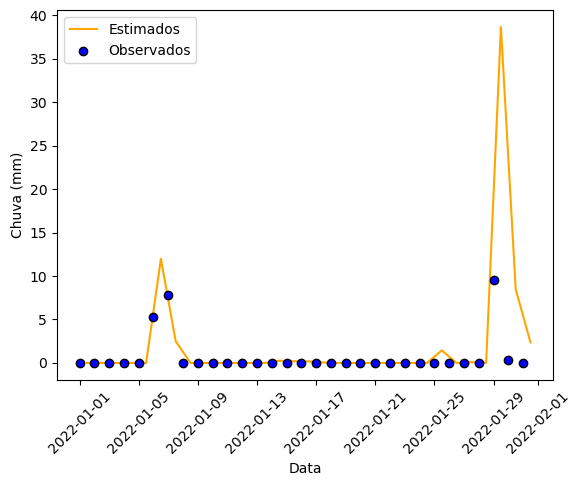

In [29]:
# Plot the rainfall
plt.plot(rainfall_gage.index, rainfall_gage['rain(mm)'], color='orange')
plt.scatter(data_filter.index, data_filter['Precipitação'], color='blue', edgecolor='black', zorder=2)

plt.xlabel('Data')
plt.ylabel('Chuva (mm)')
plt.xticks(rotation=45)
plt.legend(['Estimados', 'Observados'])
plt.show()

# Elaborar tabela de contingência

In [30]:
# Concat the observed and estimated values
rainfall = pd.DataFrame(data={'Observed_(mm)': data_filter['Precipitação'], 'Estimated_(mm)': rainfall_gage['rain(mm)'].to_list()},
                        index=data_filter.index)
rainfall.head()

,Observed_(mm),Estimated_(mm)
Data,,
2022-01-01,0.0,0.0
2022-01-02,0.0,0.0
2022-01-03,0.0,0.0
2022-01-04,0.0,0.0
2022-01-05,0.0,0.0


In [31]:
# Get binary values for rain
rainfall.loc[rainfall['Observed_(mm)'] == 0, 'Observed_(mm)'] = 0
rainfall.loc[rainfall['Observed_(mm)'] > 0, 'Observed_(mm)'] = 1
rainfall.loc[rainfall['Estimated_(mm)'] == 0, 'Estimated_(mm)'] = 0
rainfall.loc[rainfall['Estimated_(mm)'] > 0, 'Estimated_(mm)'] = 1

In [32]:
# Elaborate cross table
pd.crosstab(index=rainfall['Observed_(mm)'], columns=rainfall['Estimated_(mm)'])

Estimated_(mm),0.0,1.0
Observed_(mm),,
0.0,20,7
1.0,0,4
